<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/2022_12_02_%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>**09. 회귀 실습 - 자전거 대여 수요 예측**

1시간 간격 동안의 자전거 대여 횟수 데이터.

**데이터 클렌징 및 가공**

대여 횟수를 예측해보자. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df=pd.read_csv('bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


null은 없고 대부분이 숫자형이나 datetime은 object형. 가공이 필요. 년, 월, 일, 시간 4가지 속성으로 분리하자. datetime 타입으로 변경해야함.

In [3]:
#문자열을 datetime 타입으로 변경.
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

#datatime 타입에서 년, 월, 일, 시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x:x.year)
bike_df['month']=bike_df.datetime.apply(lambda x:x.month)
bike_df['day']=bike_df.datetime.apply(lambda x:x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


이제 필요 없는 칼럼 삭제. casual은 미등록자 대여 횟수, registered는 등록자 대여 횟수, casual+registered=count니까 이거 두 개도 삭제.

In [4]:
drop_columns=['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

바로 회귀 모델들을 데이터 세트에 적용해 예측 성능 측정하자. 캐글에서 요구한 방법은 RMSLE. 하지만 제공 안하니까 오류값의 로그에 대한 RSME 직접 만들자.

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
  log_y=np.log1p(y)
  log_pred=np.log1p(pred)
  squared_error=(log_y-log_pred)**2
  rmsle=np.sqrt(np.mean(squared_error))
  return rmsle

#사이킷런의 mean_squared_error를 이용해 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

#MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
  rmsle_val=rmsle(y, pred)
  rmse_val=rmse(y, pred)
  #MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val=mean_absolute_error(y, pred)
  print('RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

In [8]:
#주의해야할 점.
#그냥 log로 구현하면 오류가 발생할 수도 있음.

#다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽습니다.
def rmsle(y, pred):
  msle=mean_squared_log_error(y, pred)
  rmlse=np.sqrt(mse)
  return rmsle

#log 대신 log1p를 이용하면 문제 해결. 반환된 값은 expm1()함수로 쉽게 원래 스케일로 복원 가능.

**로그 변환, 피처 인코딩과 모델 학습/예측/평가**

데이터가 정규분포인가? 그리고 카테고리형 회귀 모델인 경우 원-핫 인코딩하기.

먼저 예측을 해보자.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target=bike_df['count']
X_features=bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


예측 오류치곤 큰 값. 어느 정도 차이가 나는지 오류 값이 가장 큰 순으로 5개만 확인해보자.

In [12]:
def get_top_error_data(y_test, pred, n_tops=5):
  #DF의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
  result_df=pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count']=np.round(pred)
  result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])

  #예측값과 실제값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


예측 오류 크다. 

회귀에서 예측 오류가 크면 가장 먼저 살펴볼 것은 **target값의 분포가 왜곡된 분포인지 확인**하는 것. 정규분포가 가장 좋다. 

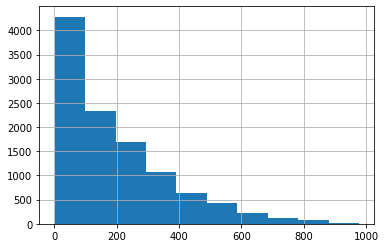

In [13]:
y_target.hist()

역시 왜곡됨.

로그를 적용해 정규 분포 형태로 바꾸는 것이 가장 일반적. 이렇게 변경된 target 값을 기반으로 학습하고 예측한 값은 다시 expm1() 함수를 적용해 원래 scale 값으로 원상 복구하면 된다. log1p()를 적용한 count 값의 분포를 확인하자.

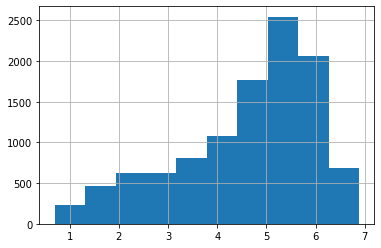

In [14]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

원했던 정규 분포 형태는 아니어도 왜곡 정도가 많이 향상됨. 이를 이용해 다시 학습하고 평가하자.

In [15]:
#타깃 칼럼인 count 값을 log1p로 변환
y_target_log=np.log1p(y_target)

#로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

#테스트 데이터 세트의 target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp=np.expm1(y_test)

#예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp=np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


rmsle 오류는 줄었으나 rmse는 오히려 증가. 왜? 각 피처 회귀 계수 값 시각화해보자.

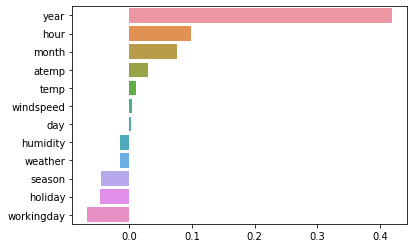

In [16]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

두 개 값 뿐인 year가 독보적. 납득 어려움. 연도는 카테고리형이지만 숫자형으로 되어 있음. 게다가 아주 큼. 이렇게 숫자형 카테고리 값을 선형 회귀에 사용하면 여기에 큰 영향을 받을 수 있음. 원-핫 인코딩 필요.

In [17]:
#year, month, day, hour 등의 피처를 원-핫 인코딩
X_features_ohe=pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

선형, 릿지, 라쏘 모두 학습해 예측 성능 확인하자. get_model_predict() 함수부터 생성하자.

In [18]:
#원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test=train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

#모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, x_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred=model.predict(X_test)
  if is_expm1:
    y_test=np.expm1(y_test)
    pred=np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)
#end of function get_model_predict

#모델별로 평가 수행
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


인코딩을 적용하니 선형 회귀의 예측 성능은 많이 향상. 인코딩된 데이터 세트에서 회귀 계수 높은 피처 다시 시각화하자.

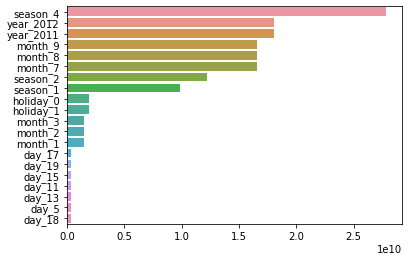

In [19]:
coef=pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

월 관련 피처들과 workingday 관련 피처들, hour 관련 피처들의 회귀 계수 높다. 이렇게 선형 회귀 수행 시 피처 인코딩 방법이 성능에 큰 영향.

이제는 회귀 트리를 이용해 예측을 수행. target의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용.

In [20]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#랜덤 포레스트, GBM, XGBoost, LGBM 모델별로 평가 수행
rf_reg=RandomForestRegressor(n_estimators=500)
gbm_reg=GradientBoostingRegressor(n_estimators=500)
xgb_reg=XGBRegressor(n_estimators=500)
lgbm_reg=LGBMRegressor(n_estimaotrs=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  #XGBoost의 경우 DF가 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


### RandomForestRegressor ###
RMSLE : 0.355, RMSE : 50.397, MAE : 31.127


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.347, MAE : 32.743
[10:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ValueError: ignored

앞의 선형 회귀보다 회귀 예측 성능 개선. 하지만 회귀 트리가 선형 회귀보다 낫다는 이야기는 아님.


>**10. 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법**

앞과 동일한 RMSLE를 기반으로 성능 평가. 가격 비싼 주택일수록 예측 결과 오류가 전체 오류에 주는 영향이 크므로 상쇄하기 위해 오류 값을 로그 변환한 RMSLE 이용.

**데이터 사전 처리**

데이터 가공 많으므로 원본 DF 보관하고 복사해서 가공할 것.

In [21]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org=pd.read_csv('house_price.csv')
house_df=house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


SalePrice 값이 타깃. 데이터 세트의 전체 크기와 칼럼 타입, null이 있는 칼럼과 건수를 출력하자.

In [22]:
print('데이터 세트의 shape : ', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series=house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 shape :  (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


null 1000개 넘는 피처도 있음. 이건 드롭.

타깃 값 분포도 정규 분포인가? 아님.

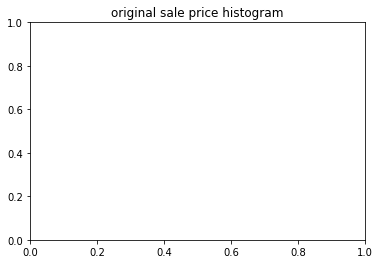

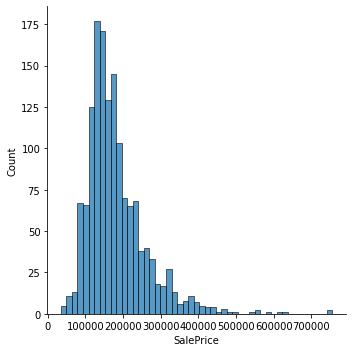

In [23]:
plt.title('original sale price histogram')
sns.displot(house_df_org['SalePrice'])

로그 변환 하자.

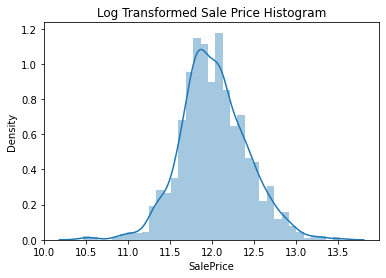

In [24]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

정규분포! 이제 saleprice를 로그 변환하여 DF에 반영하자.

null 많은 피처는 삭제하자. id도 단순 식별자이므로 삭제.

lotfrontage는 null이 많긴하나 평균으로 대체함. 나머지 null은 숫자형의 경우 평균값으로 대체.

In [25]:
#saleprice 로그 변환
original_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

#null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
#드롭하지 않은 숫자형 null 칼럼은 평균으로 대체
house_df.fillna(house_df.mean(), inplace=True)
#null 있는 피처명과 타입 추출
null_column_count=house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


이제 문자형 말고는 null 없다. 문자형은 모두 원-핫 인코딩으로 변환. 원-핫 인코딩 시 get_dummies()는 null을 자동으로 none 칼럼으로 대체해준다.

In [26]:
print('get_dummies() 수행 전 데이터 shape:', house_df.shape)
house_df_ohe=pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:', house_df_ohe.shape)

null_column_count=house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 271)
## Null 피처의 type :
 Series([], dtype: object)


null 없다. 이제 회귀 모델 생성해 학습 후 예측 결과 평가해보자.

**선형 회귀 모델 학습/예측/평가**

RMSLE(실제 값과 예측 값의 오류를 로그 변환한 뒤 RMSE 적용) 이용. 이미 타깃 값인 SalePrice가 로그 변환됨. 예측 값 역시 로그 변환된 값을 기반으로 예측하므로 원본 saleprice 예측값의 로그 변환 값. 따라서 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정된다.

여러 모델의 로그 변환된 RMSE를 측정할 것이므로 이를 계산하는 함수 생성.

In [27]:
def get_rmse(model):
  pred=model.predict(X_test)
  mse=mean_squared_error(y_test, pred)
  rmse=np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses=[]
  for model in models:
    rmse=get_rmse(model)
    rmses.append(rmse)
  return rmses

get_rmse는 단일 모델의 rmse 값을, get_rmses는 get_rmse를 이용해 여러 모델의 RMSE를 반환.

이제 선형 회귀 모델을 학습하고 예측, 평가해보자.

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

#LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso()
lasso_reg.fit(X_train, y_train)

models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579153628, 0.12750846334052995, 0.17628250556471403]

라쏘의 성능이 다른 방식보다 좀 떨어진다. 라쏘의 경우 최적 하이퍼 파라미터 튜닝이 필요해보임. alpha 하이퍼 파라미터 최적화를 릿지와 라쏘 모델에 대해 수행하자.

먼저 피처별 회귀 계수 시각화하여 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인하자. 피처 많으니 상/하위 10개 피처명과 그 회귀 계수 값을 가지는 series 객체를 반환하는 함수를 만들자.

In [29]:
def get_top_bottom_coef(model, n=10):
  #coef_ 속성을 기반으로 series 객체를 생성. index는 칼럼명.
  coef=pd.Series(model.coef_, index=X_features.columns)

  #+상위 10개, -하위 10개 회귀 계수를 추출해 반환.
  coef_high=coef.sort_values(ascending=False).head(n)
  coef_low=coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

생성한 함수를 이용해 모델별 회귀 계수를 시각화하자. visualize_coefficient(models) 생성.

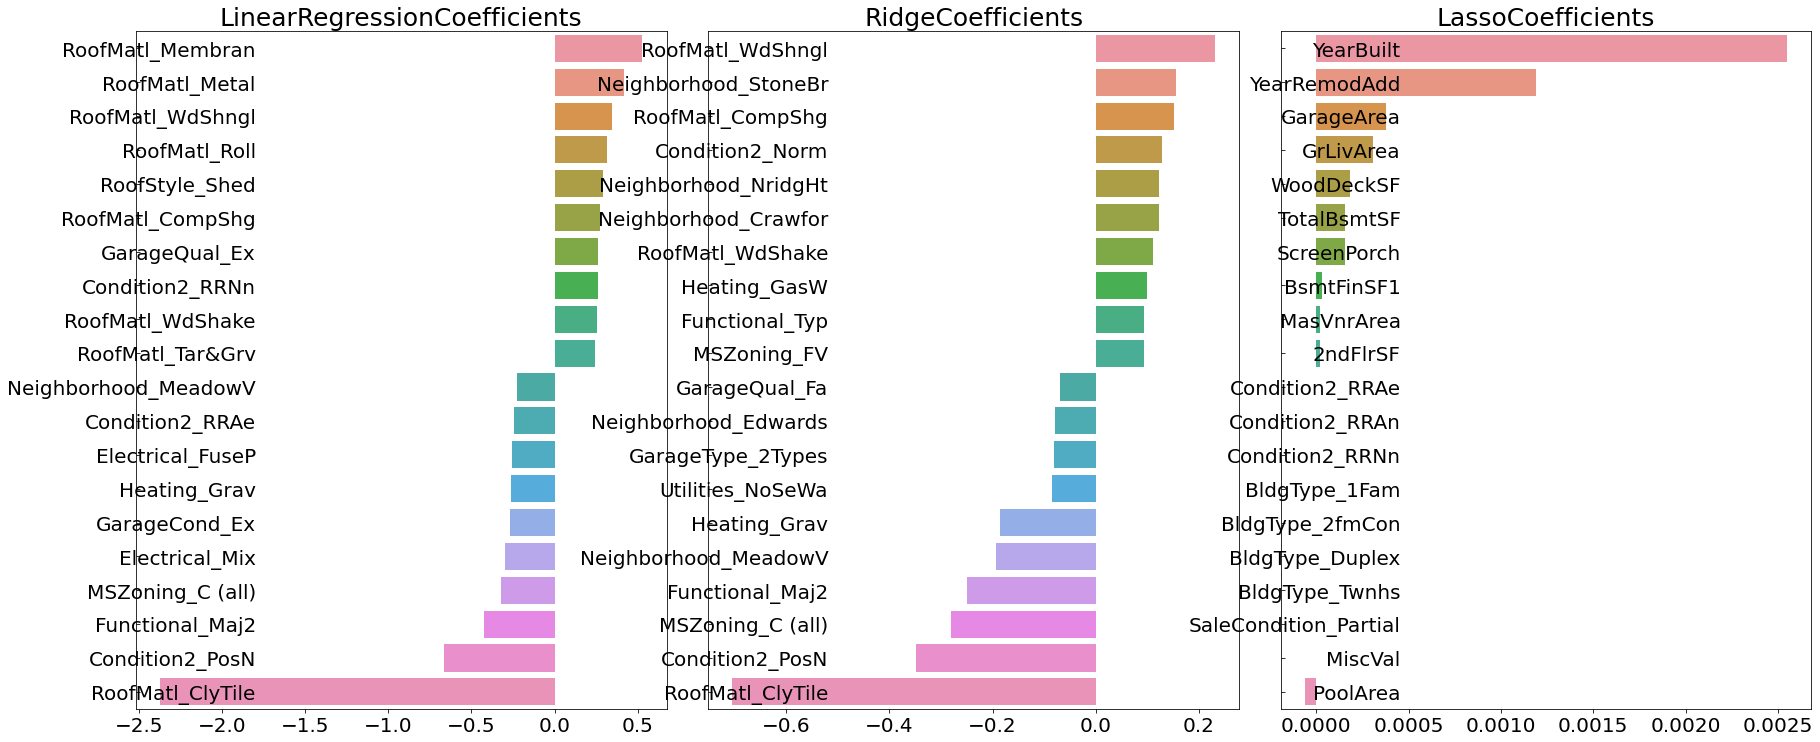

In [30]:
def visualize_coefficient(models):
  #3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs=plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()
  #입력 인자로 받은 list 객체인 models에서 차례로 model 추출해 회귀 계수 시각화.
  for i_num, model in enumerate(models):
    #상위 10개, 하위 10개 회귀 계수를 구하고 이를 판다스 concat으로 결합
    coef_high, coef_low=get_top_bottom_coef(model)
    coef_concat=pd.concat([coef_high, coef_low])
    #ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
    axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
    axs[i_num].tick_params(axis='y', direction='in', pad=-120)
    for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
      label.set_fontsize(20)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

#앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

OLS 기반의 linear regression과 릿지는 유사한 형태로 분포. 하지만 라쏘는 대체적으로 값이 매우 작고, yearbuilt가 가장 크고 나머지는 너무 작다. 다른 형태를 보임.

학습 데이터의 데이터 분할에서 문제? train_test_split 말고 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정해보자. cross_val_score() 이용.

In [31]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    #분할하지 않고 전체 데이터로 cross_val_score 수행. 모델별 CV RMSE 값과 평균 RMSE 출력
    rmse_list=np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
    rmse_avg=np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

#앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


이렇게 해도 여전히 라쏘가 성능이 떨이진다. 릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터 변화시키며 최적 값을 도출하자.

먼저 최적화 하이퍼 파라미터 작업을 위한 함수 생성.

In [32]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model=GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse=np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params={'alpha':[0.01, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


alpha 값 최적화 이후 라쏘 모델의 예측 성능이 많이 좋아졌다. 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 하고 모델별 회귀 계수 시각화하자.

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


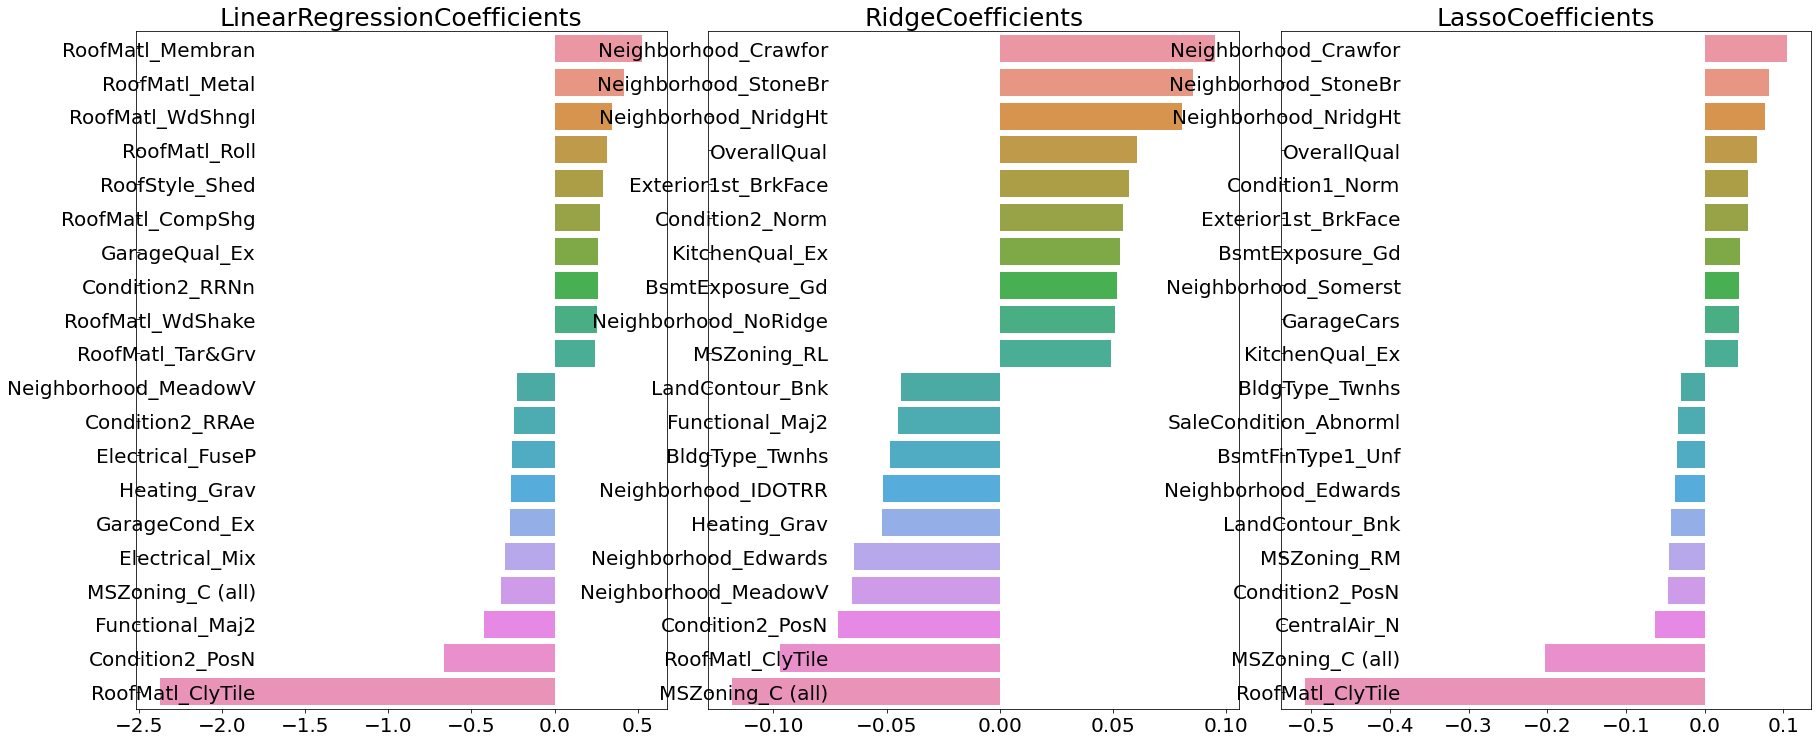

In [33]:
#앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

최적화 후 예측 성능 향상됨. 회귀 계수도 많이 달라짐. 기존보다 릿지와 라쏘 모델에서 비슷한 회귀 계수가 많다. 다만 라쏘는 릿지에 비해 동일한 피처라도 회귀 계수 값이 상당히 작다.

추가적으로 가공해 모델 튜닝을 더 진행하자.
1. 피처 데이터 세트의 데이터 분포도
2. 이상치 데이터 처리

1.
예제 처음에서 타깃 데이터 세트의 왜곡 확인. 어느 정도로 왜곡됨? 사이파이 stats 모듈의 skew() 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 쉽게 추출할 수 있다. 1이상일 경우 왜곡 높다고 일반적으로 판단. 1이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환 적용하자. 주의할 점은 skew()를 적용하는 숫자형 피처에서 원-핫 인코딩 된 카테고리 숫자형 피처는 제외해야함. 코드성 피처이므로. skew() 적용하는 DF는 원-핫 인코딩 안된 house_df

In [34]:
from scipy.stats import skew

#object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index=house_df.dtypes[house_df.dtypes != 'object'].index
#house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features=house_df[features_index].apply(lambda x:skew(x))
#skew 정도가 1 이상인 칼럼만 추출
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [35]:
#이 피처들 로그 변환
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

다시 원-핫 인코딩 진행해 house_df_ohe 만들자. 이에 기반한 피처 데이터 세트와 타깃, 학습/테스트 데이터 모두 다시 만들자. 최적 alpha값과 RMSE도 출력하자.

In [36]:
#왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

#피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params={'alpha':[0.01, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


이제 최적 알파는 릿지는 10, 라쏘는 0.001. 피처의 로그 변환 이전보다 둘 다 5 폴드 교차 검증의 평균 RMSE 값이 향상됐다.

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


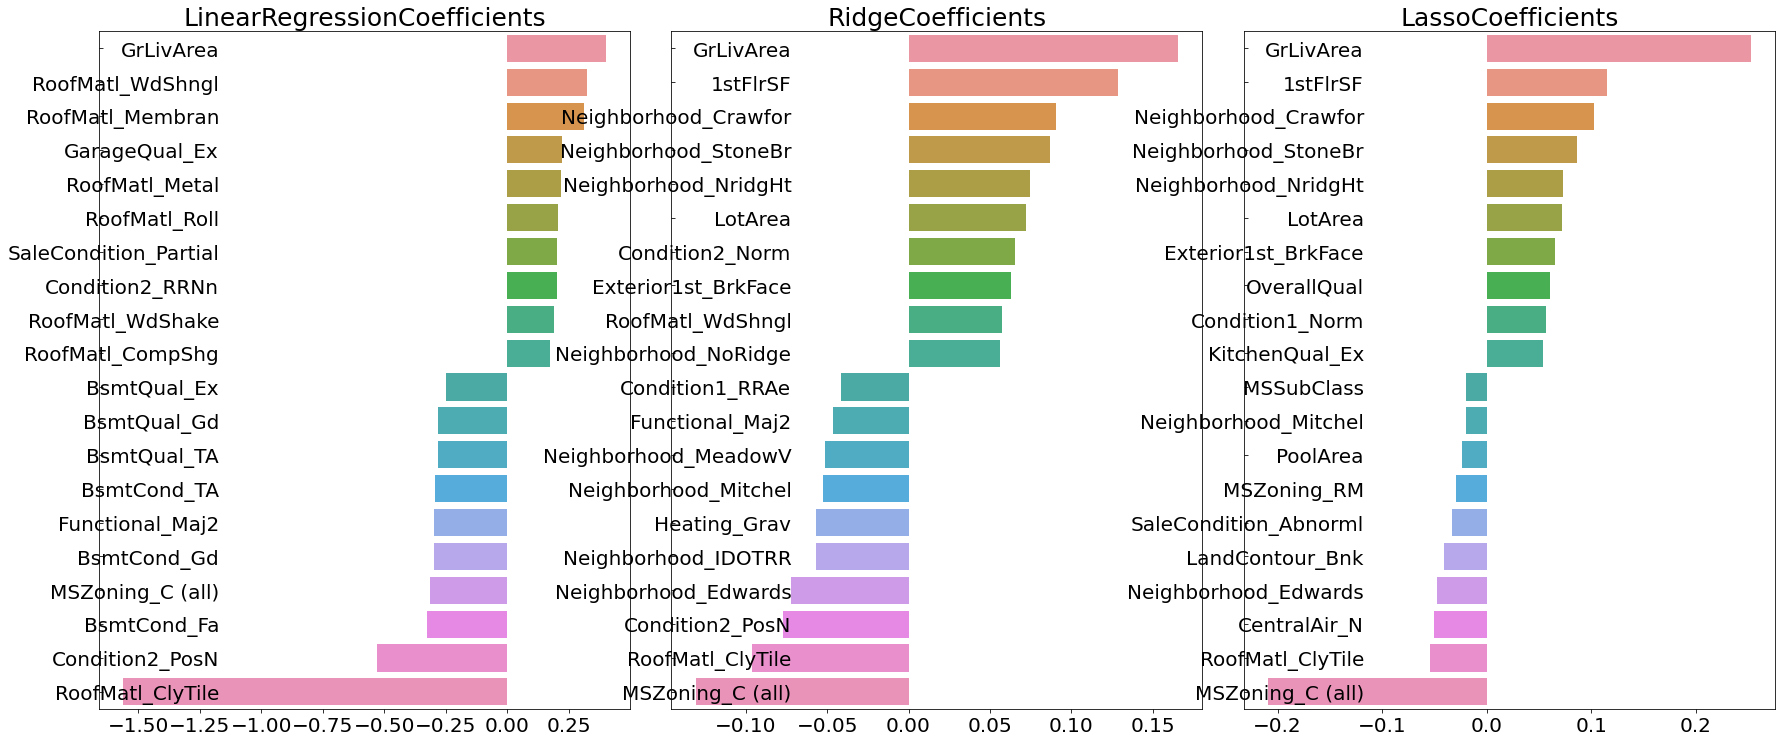

In [37]:
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

회귀 계수 시각화 결과를 보니 세 모델 모두 GrLivArea 즉 주거 공간 크기가 회귀 계수가 가장 높은 피처가 됨.

2. 이제 이상치 데이터 보자. 세 모델에서 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포 살펴보자.

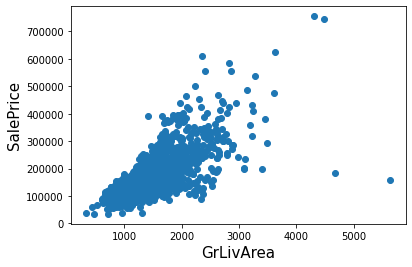

In [38]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

2개의 이상치. 불린 인덱싱으로 찾아 삭제할거임.

In [39]:
#GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1=house_df_ohe['GrLivArea']>np.log1p(4000)
cond2=house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index=house_df_ohe[cond1&cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

#DF의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


업데이트된 house_df_ohe를 기반으로 피처 데이터 세트와 타깃 데이터 세트 다시 생성하고 앞에서 정의한 print_best_params 함수를 이용해 릿지와 라쏘 모델의 최적화를 수행하고 결과를 출력하자.

In [40]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params={'alpha':[0.01, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


예측 수치 매우 향상. 최적 알파 값도 변함. 이상치 제거의 중요성. 처음부터 완벽히 데이터를 전처리하기보단 대략의 가공과 모델 최적화를 진행한 후 다시 이에 기반한 여러 가공과 하이퍼 파라미터 기반의 최적화를 반복적으로 수행하는 것이 바람직.

다시 분할하고 시각화하면 결과는 다음과 같다.

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


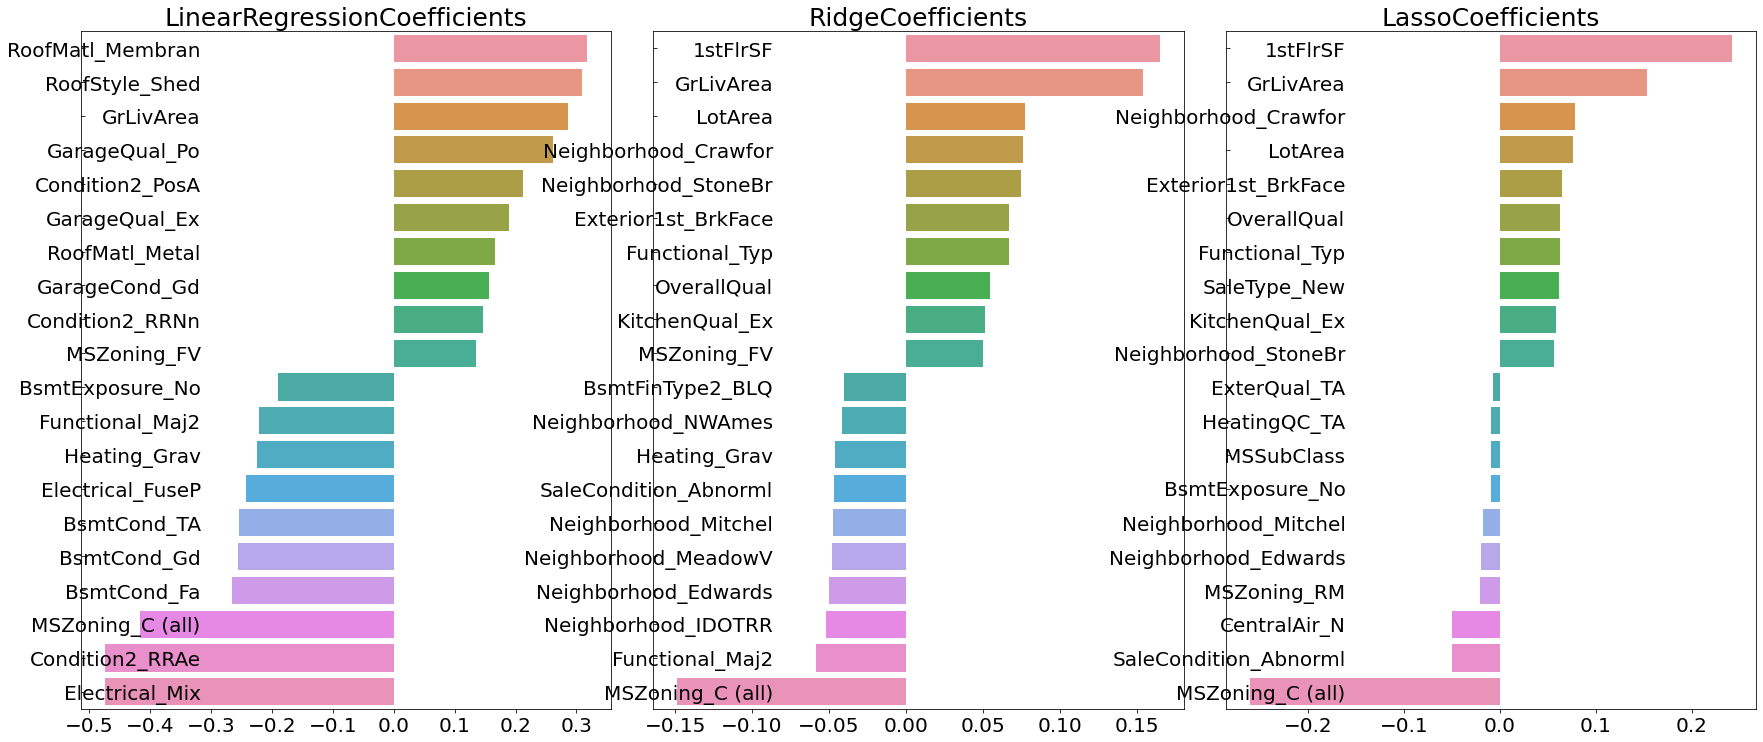

In [41]:
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

**회귀 트리 모델 학습/예측/평가**

이제는 회귀 트리 이요해 모델을 만들어보자.

In [42]:
from xgboost import XGBRegressor

xgb_params={'n_estimators':[1000]}
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

[10:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.115, 최적 alpha:{'n_estimators': 1000}


In [43]:
from lightgbm import LGBMRegressor

lgbm_params={'n_estimators':[1000]}
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.1161, 최적 alpha:{'n_estimators': 1000}


**회귀 모델의 예측 결과 혼합을 통한 최종 예측**

최종 회귀 값 예측하자. 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 get_rmse_pred() 함수를 생성하고 각 모델의 예측값을 계산한 뒤 개별 모델과 최종 혼합 모델의 RMSE를 구한다.

In [44]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value=preds[key]
    mse=mean_squared_error(y_test, pred_value)
    rmse=np.sqrt(mse)
    print('{0} 모델의 RMSE: {1}'.format(key, rmse))

#개별 모델 학습
ridge_reg=Ridge(alpha=0.8)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
#개별 모델 예측
ridge_pred=ridge_reg.predict(X_test)
lasso_pred=lasso_reg.predict(X_test)

#개별 모델 예측값 혼합으로 최종 예측값 도출
pred=0.4*ridge_pred+0.6*lasso_pred
preds={'최종 혼합': pred, 'Ridge': ridge_pred, 'Lasso': lasso_pred}

#최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10123104084844879
Ridge 모델의 RMSE: 0.1129073687594882
Lasso 모델의 RMSE: 0.10024170460890035


약간 개선. xgboost와 lgbm을 혼합하면?

In [45]:
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred=xgb_reg.predict(X_test)
lgbm_pred=lgbm_reg.predict(X_test)

pred=0.5*xgb_pred+0.5*lgbm_pred
preds={'최종 혼합':pred, 'XGBM':xgb_pred, 'LGBM':lgbm_pred}

get_rmse_pred(preds)

[10:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.09897715854093486
XGBM 모델의 RMSE: 0.10075115846547565
LGBM 모델의 RMSE: 0.1015065721553885


개별보다 약간 개선!

**스태킹 앙상블 모델을 통한 회귀 예측**

두 종류 모델 필요. 개별적 기반 모델과 최종 메타 모델. 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것.

개별 모델을 스태킹 모델로 제공하기 위해 데이터 세트를 생성하기 위한 get_stacking_base_datasets() 함수

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  #지정된 n_folds 값으로 KFold 생성.
  kf=KFold(n_splits=n_folds, shuffle=False, random_state=0)
  #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred=np.zeros((X_train_n.shape[0], 1))
  test_pred=np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    #입력된 학습 뎅터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_test_n[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
    #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:, folder_counter]=model.predict(X_test_n)

  #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

이제 모델별로 적용해 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 피처 데이터 세트를 추출하자.

In [47]:
#get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DF을 넘파이로 변환.
X_train_n=X_train.values
X_test_n=X_test.values
y_train_n=y_train.values

#각 개별 기반 모델이 생성한 학습/테스트용 데이터 반환
ridge_train, ridge_test=get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test=get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test=get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test=get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

ValueError: ignored

최종 메타 모델에 적용하자.

In [48]:
#개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train=np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test=np.comcatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

#최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso=Lasso(alpha=0.0005)

#개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final=meta_model_lasso.predict(Stack_final_X_test)
mse=mean_squared_error(y_test, final)
rmse=np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

NameError: ignored

0.0972 정도로 지금까지 중에 가장 성능이 좋다. 스태킹의 효과!